<a href="https://colab.research.google.com/github/vyvy-2001/Evaluation-of-Recommendation-Systems-techniques/blob/main/EDA_Movie_Recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-ratings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F33019%2F43260%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T065724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D755670d09029af4744b1b78dcf7c8a1ae94ea1ddfe394616fbb56d4507000f739035fd52d7f458322b3263ce774ac45bf923d5ae05be7c212f8e517a74eae482ff24fd1ca496d98a06dd51d1642a1b05bd25ab9916fd537316e6f776343eef586a15604068a71a8057c5ba79f6e66a405cec5997ac133c173615970761583731aeb75e58380130e2a6415d4a8970a9add7a87a6176806fd710ad2e910de34edbffa0facf1ef801fbb7f3695c92ce0e57285365c6b9359e14e353ffe36537f19c76be1ff07239c4a3c211ea8c393c08c0d9d272d654a0ec09ac9c6b9eb6662ecdd23f44109ca3fa108617fa49e3290f97d1ade68da1108b39dfee0f20736cb1dc,movies-and-ratings-for-recommendation-system:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3747724%2F6486174%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T065725Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbcc4d58fb822627941f966f9224099a77c2a40e714df25bdb6f659cfe4afad3f5b266ab7c2b5f184b240a7803ffba7a4eb8f00c5e00d10501c43f48d1b679ffbda0554476dee6bcee6eab9aa36bbbf7e0fe104652a339d5d7f48915c912d2f2fadc5922be266f5baa54256157f013e476714331bad4761402f5a7a4255c31cb9286752eb51541eaf98cf524e8be8243216a22489e4deaae00ab0ae45d8b5faad76b88dc9e64493d7a3287dca018895bbcf1f948010408b24febdad398810e007c1091b2f0122bc60f2d84707bd2cfce38af0fbcf27f48d8fa9c586a1b3433ef371ab538944afd1bb7039ae26ccd071c00ab9af6ce86641eb33c6e6e3a23bdbe2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn

In [ ]:
#Data preprocessing
def unique_counts_df(df):
    unique_counts = df.nunique()
    unique_values = [pd.Series(df[column].unique()) for column in df.columns] # Convert unique values to Series
    data_types = [str(df[column].dtype) for column in df.columns]
    unique_counts_df = pd.DataFrame({'feature': df.columns, 'unique_count': unique_counts, 'unique_values': unique_values, 'data_type': data_types})
    return unique_counts_df

In [ ]:
movie_info = pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/movies.csv')
movie_info

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
rating = pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/ratings.csv')
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
rate = pd.merge(rating, movie_info, on = 'movieId', how = 'left')
rate['timestamp'] = pd.to_datetime(rate['timestamp'])

# We don't need movies that is rated by less then 10 users so drop them and fill NaN with 0
rated = rate.dropna(thresh=10, axis=1).fillna(0)
rated.set_index('userId', inplace=True)
rated

,movieId,rating,timestamp,title,genres
userId,,,,,
1,1,4.0,1970-01-01 00:00:00.964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,4.0,1970-01-01 00:00:00.964981247,Grumpier Old Men (1995),Comedy|Romance
1,6,4.0,1970-01-01 00:00:00.964982224,Heat (1995),Action|Crime|Thriller
1,47,5.0,1970-01-01 00:00:00.964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
1,50,5.0,1970-01-01 00:00:00.964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
610,166534,4.0,1970-01-01 00:00:01.493848402,Split (2017),Drama|Horror|Thriller
610,168248,5.0,1970-01-01 00:00:01.493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
610,168250,5.0,1970-01-01 00:00:01.494273047,Get Out (2017),Horror


In [ ]:
rated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100836 entries, 1 to 610
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   movieId    100836 non-null  int64         
 1   rating     100836 non-null  float64       
 2   timestamp  100836 non-null  datetime64[ns]
 3   title      100836 non-null  object        
 4   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [ ]:
count_rated = unique_counts_df(rated)
count_rated

,feature,unique_count,unique_values,data_type
movieId,movieId,9724,0 1 1 3 2 6 3...,int64
rating,rating,10,0 4.0 1 5.0 2 3.0 3 2.0 4 1.0 5...,float64
timestamp,timestamp,85043,0 1970-01-01 00:00:00.964982703 1 ...,datetime64[ns]
title,title,9719,0 Toy Story (1995) 1 ...,object
genres,genres,951,0 Adventure|Animation|Children|Comedy|Fan...,object


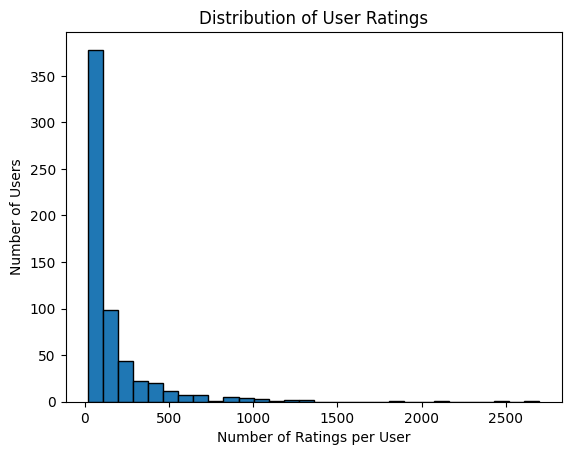

In [ ]:
user_counts = rated.index.value_counts()

plt.hist(user_counts, bins=30, edgecolor='black')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('Distribution of User Ratings')
plt.show()

In [ ]:
#EDA Process
#Calculate average rating for each product
movie_ranking = rated.groupby(['movieId'])['rating'].mean().reset_index().sort_values(by = 'rating', ascending=False)
movie_ranking

,movieId,rating
7638,88448,5.0
8089,100556,5.0
9065,143031,5.0
9076,143511,5.0
9078,143559,5.0
...,...,...
9253,157172,0.5
7536,85334,0.5
6486,53453,0.5
5200,8494,0.5


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


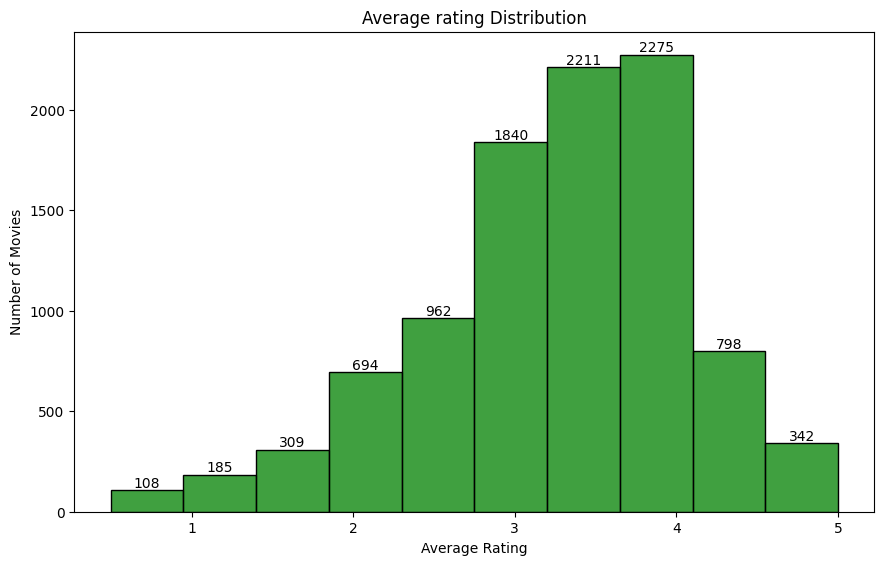

In [ ]:
#Create the distribution of average rating for each product
plt.figure(figsize=(10, 6))
hist = sns.histplot(data=movie_ranking, x='rating', bins=10, color='green', edgecolor='black')
plt.title('Average rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.bar_label(plt.gca().containers[0])
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('Average rating Distribution.png')
plt.show()

In [ ]:
# Calculate the frequency of ratings
rating_counts = rated['rating'].value_counts().sort_index()
rating_counts

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

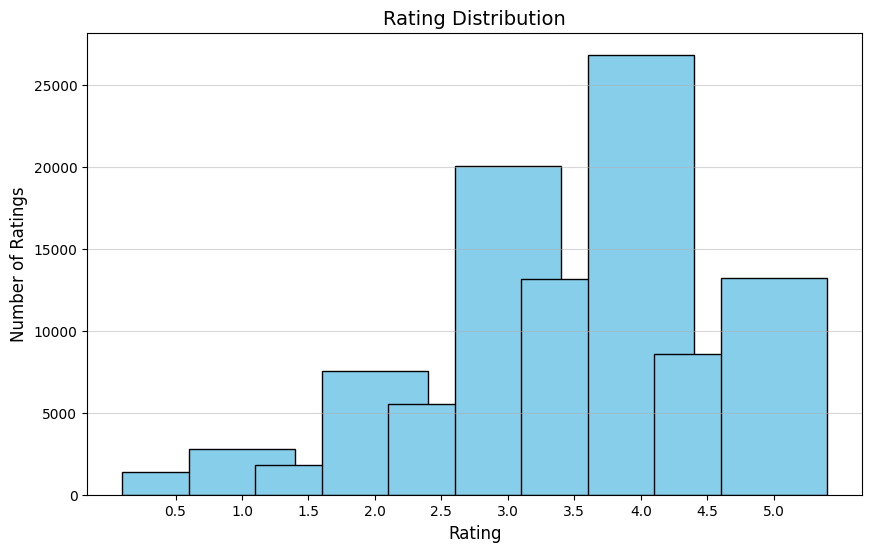

In [ ]:
# Extract data for plotting
ratings = rating_counts.index.tolist()
counts = rating_counts.values.tolist()

# Create the bar chart (rest of the code remains the same)
plt.figure(figsize=(10, 6))
plt.bar(ratings, counts, color='skyblue', edgecolor='black')

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Rating Distribution', fontsize=14)

plt.xticks(ratings, ratings)  # Set both positions and labels of x-ticks
plt.grid(axis='y', alpha=0.5)
plt.savefig('Rating Distribution.png')
plt.show()

In [ ]:
#Create top 10 movies that receive rating regularly
top_10_movies = rated.groupby(['title'])['rating'].count().reset_index().sort_values(by = 'rating', ascending=False)
top_10_movies = top_10_movies.rename(columns={'rating': 'Number of Ratings'})
top_10_movies.head()

movie_ratings = rated.pivot_table(index='title', columns='rating', values='timestamp', aggfunc='count', fill_value=0)
movie_ratings.columns = ['rating ' + str(col) for col in movie_ratings.columns]
movie_ratings['Frequency'] = movie_ratings.sum(axis=1)
top10_movies = movie_ratings.nlargest(10, 'Frequency').drop(columns=['Frequency'])
top10_movies

,rating 0.5,rating 1.0,rating 1.5,rating 2.0,rating 2.5,rating 3.0,rating 3.5,rating 4.0,rating 4.5,rating 5.0
title,,,,,,,,,,
Forrest Gump (1994),1,1,0,9,3,39,27,94,39,116
"Shawshank Redemption, The (1994)",0,2,0,2,0,24,15,72,49,153
Pulp Fiction (1994),2,6,0,9,3,31,12,77,44,123
"Silence of the Lambs, The (1991)",3,1,0,5,7,24,14,97,36,92
"Matrix, The (1999)",5,4,0,5,7,17,18,72,41,109
Star Wars: Episode IV - A New Hope (1977),1,1,1,9,5,14,19,73,24,104
Jurassic Park (1993),1,1,0,15,5,48,23,97,8,40
Braveheart (1995),1,4,3,5,6,30,22,65,21,80
Terminator 2: Judgment Day (1991),3,2,0,3,6,37,23,67,19,64


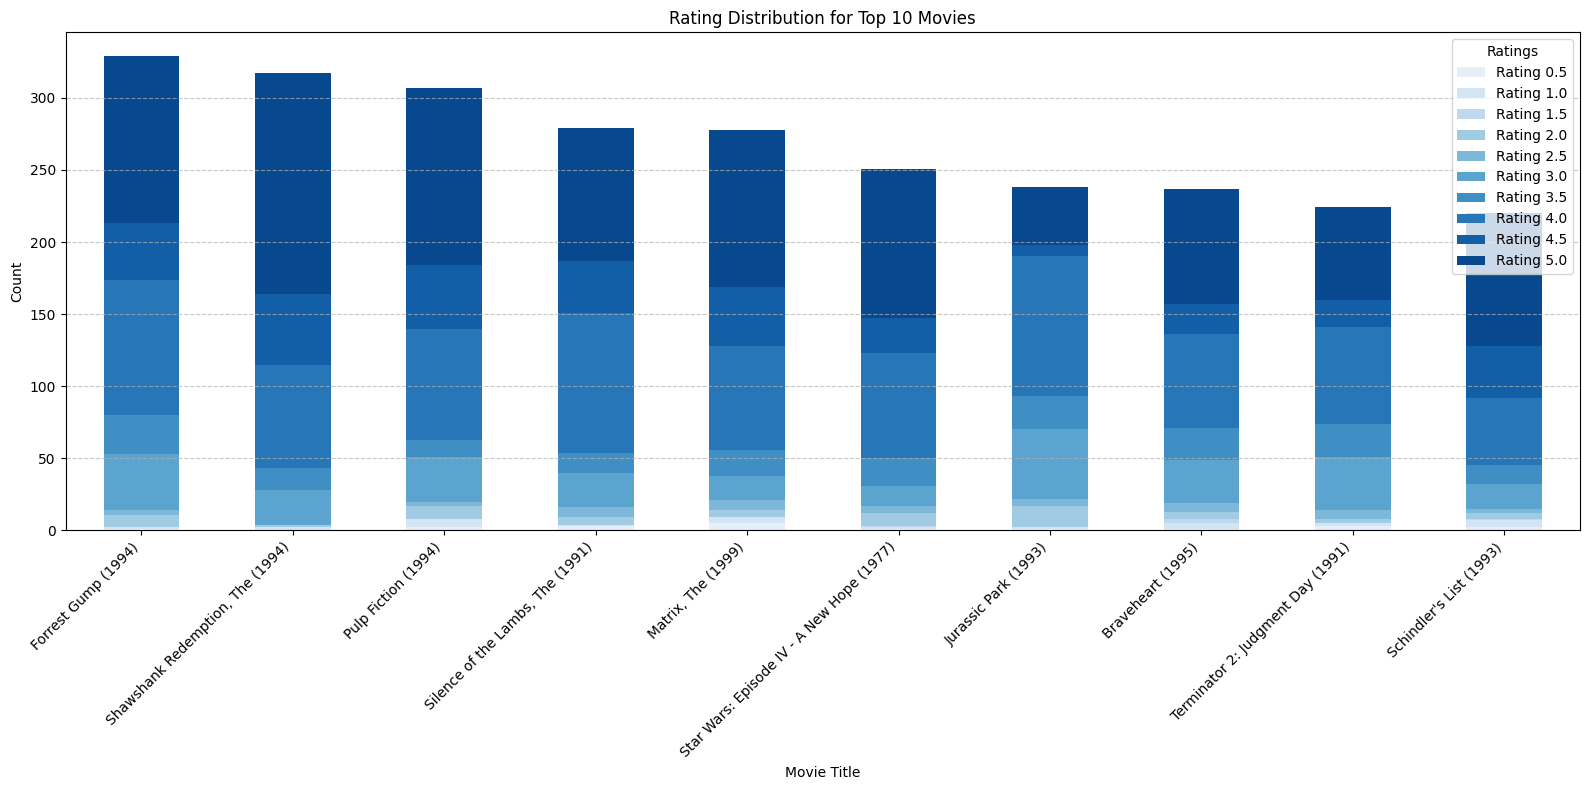

In [ ]:
# Define a color palette
colors = sns.color_palette('Blues', n_colors=10)

# Create the stacked bar chart
movie_frequent = top10_movies.plot(kind='bar', stacked=True, figsize=(16, 8), color=colors)

# Explicitly create the legend with desired labels
legend_labels = [f'Rating {i}' for i in np.arange(0.5, 5.5, 0.5)]
movie_frequent.legend(legend_labels, title='Ratings', loc='upper right')

# Add labels and title
movie_frequent.set_ylabel('Count')
movie_frequent.set_xlabel('Movie Title')
movie_frequent.set_title('Rating Distribution for Top 10 Movies')
plt.xticks(rotation= 45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Rating Distribution for Top 10 Movies.png')
plt.show()

In [ ]:
movie_ratings =rated.pivot_table(index='userId', columns='rating', aggfunc='size', fill_value=0)
movie_ratings.columns = ['rating ' + str(col) for col in movie_ratings.columns]
movie_ratings['Rating Frequency'] = movie_ratings.sum(axis=1)
movie_ratings = movie_ratings.sort_values(by = 'Rating Frequency', ascending = False)
top10 = movie_ratings.nlargest(10, 'Rating Frequency').drop(columns=['Rating Frequency'])
top10

,rating 0.5,rating 1.0,rating 1.5,rating 2.0,rating 2.5,rating 3.0,rating 3.5,rating 4.0,rating 4.5,rating 5.0
userId,,,,,,,,,,
414,1,40,20,398,122,658,232,903,76,248
599,42,67,226,349,690,624,290,122,36,32
474,9,36,37,173,103,383,580,569,159,59
448,26,85,164,334,180,482,138,337,43,75
274,2,15,37,118,139,246,472,243,63,11
610,3,13,11,42,74,230,315,286,148,180
68,8,28,21,118,156,299,279,187,113,51
380,2,16,0,94,13,399,25,391,4,274
606,4,6,13,22,79,137,241,441,139,33


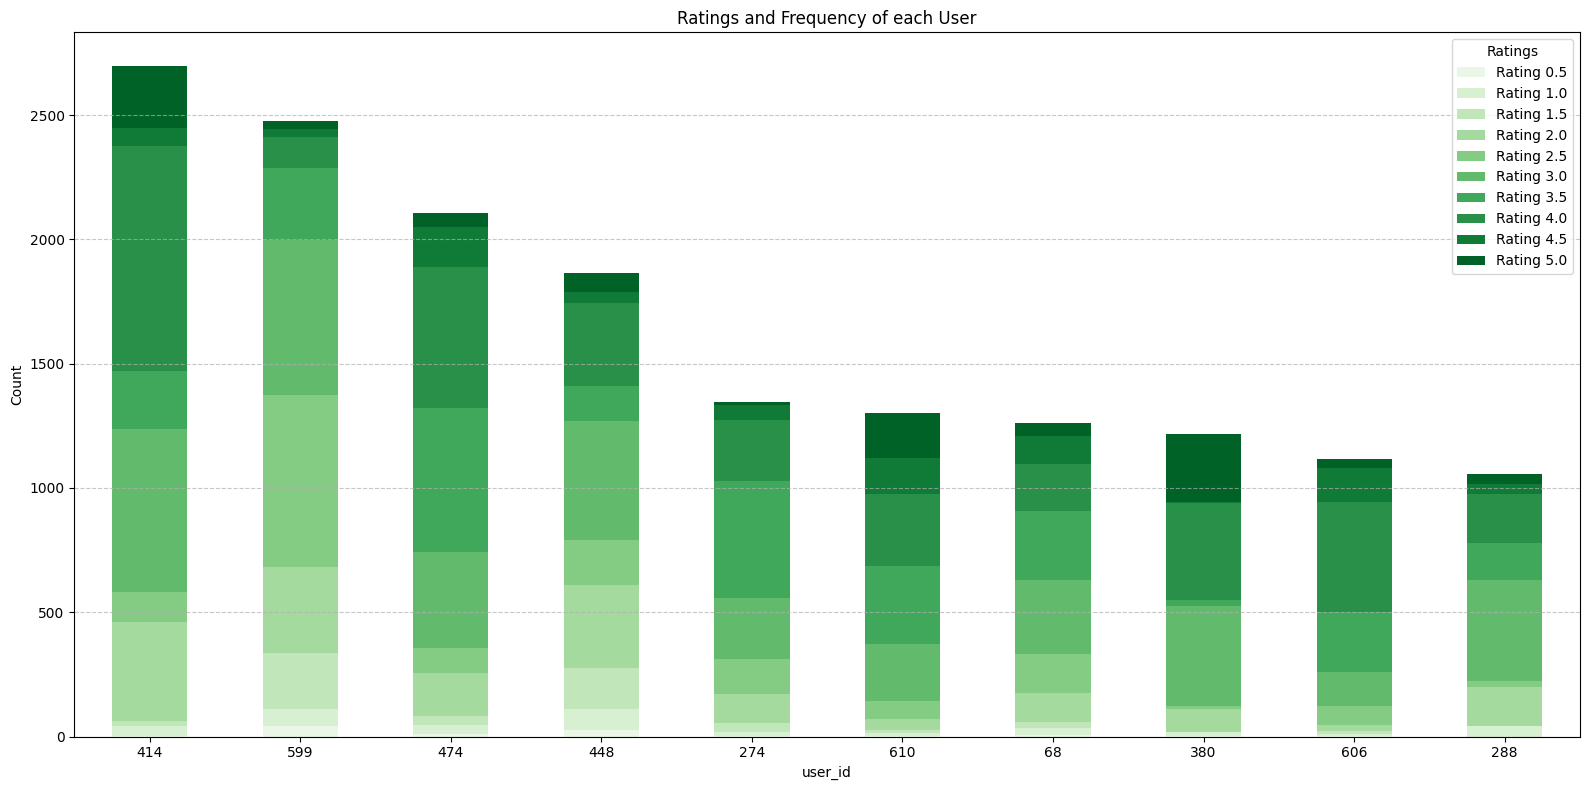

In [ ]:
# Define a color palette
colors = sns.color_palette('Greens', n_colors=10)

# Create the stacked bar chart
user_frequent = top10.plot(kind='bar', stacked=True, figsize=(16, 8), color=colors)

# Explicitly create the legend with desired labels
legend_labels = [f'Rating {i}' for i in np.arange(0.5, 5.5, 0.5)]
user_frequent.legend(legend_labels, title='Ratings', loc='upper right')

# Add labels and title
user_frequent.set_ylabel('Count')
user_frequent.set_xlabel('user_id')
user_frequent.set_title('Ratings and Frequency of each User')
plt.xticks(rotation= 0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Ratings and Frequency of each User.png')
plt.show()

In [ ]:
# 2. Filter for 5-star ratings
five_star_ratings_data = rated[rated['rating'] == 5.0]

# 3. Aggregate by movieId and count
five_star_ratings = five_star_ratings_data['movieId'].value_counts()

# 4. Sort in descending order
five_star_ratings = five_star_ratings.sort_values(ascending=False)

# 5. Select top 10
top_10_five_star_ratings = five_star_ratings.head(10)

# 6. Merge with original DataFrame to get titles
top_10_movies_with_titles = top_10_five_star_ratings.reset_index()
top_10_movies= pd.merge(movie_info, top_10_movies_with_titles, on = 'movieId')
top_10_movies = top_10_movies.sort_values('count',ascending = False)
top_10_movies

,movieId,title,genres,count
3,318,"Shawshank Redemption, The (1994)",Crime|Drama,153
2,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,123
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,116
8,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,109
1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,104
5,527,Schindler's List (1993),Drama|War,92
6,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,92
7,858,"Godfather, The (1972)",Crime|Drama,88
9,2959,Fight Club (1999),Action|Crime|Drama|Thriller,81
0,110,Braveheart (1995),Action|Drama|War,80


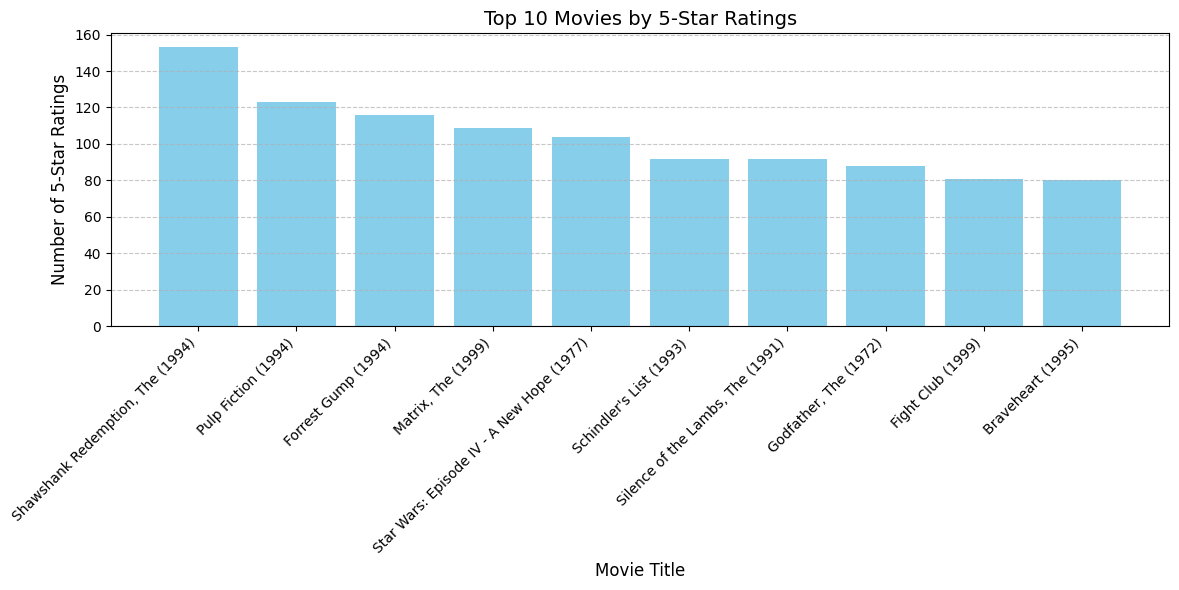

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(top_10_movies['title'], top_10_movies['count'], color='skyblue')

# 8. Customize chart
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Number of 5-Star Ratings', fontsize=12)
plt.title('Top 10 Movies by 5-Star Ratings', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Top 10 Movies by 5-Star Ratings.png')
plt.show()

In [ ]:
# 2. Filter for 5-star ratings
five_star_ratings_data = rated[rated['rating'] == 5.0]

# 3. Aggregate by movieId and count
five_star_ratings = five_star_ratings_data['genres'].value_counts()

# 4. Sort in descending order
five_star_ratings = five_star_ratings.sort_values(ascending=False)

# 5. Select top 10
top_10_five_star_ratings = five_star_ratings.head(10)

# 6. Merge with original DataFrame to get titles
top_10_movies_with_titles = top_10_five_star_ratings.reset_index()
top_10_movies= pd.merge(movie_info, top_10_movies_with_titles, on = 'genres')
top_10_movies = top_10_movies.sort_values('count',ascending = False)
top_10_movies

,movieId,title,genres,count
1888,6454,Music Box (1989),Drama,895
1017,3214,American Flyers (1985),Drama,895
2473,33421,Dear Wendy (2005),Drama,895
1014,3201,Five Easy Pieces (1970),Drama,895
1009,3192,"Terrorist, The (a.k.a. Malli) (Theeviravaathi)...",Drama,895
...,...,...,...,...
263,632,Land and Freedom (Tierra y libertad) (1995),Drama|War,256
2639,48649,Chapayev (1934),Drama|War,256
2797,60046,"Children of Huang Shi, The (2008)",Drama|War,256
3203,98154,Lincoln (2012),Drama|War,256
